# Building a ChatBot using LangGraph Part - II

- Bot From Part I
- Adding Memory
- Add Human In the Loop

## Bot With Memory and Human In the loop

### Installing Packages

In [ ]:
#!pip install -U langgraph langsmith

### Create a StateGraph

In [1]:
from typing import Annotated
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages


1. StateGraph - It structures the chatbot as state machine. (messages is schema, and append to the list is done by reducer functions)
2. Nodes - Calling LLM/Function.
3. Edges - transistion between the functions.

### Creating Structure of a Bot

In [2]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

### Loading API Keys

In [3]:
import os
from dotenv import load_dotenv
from langchain.chat_models import init_chat_model

load_dotenv()
os.environ["GOOGLE_API_KEY"] = os.getenv("GEMINI_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")

llm = init_chat_model("google_genai:gemini-2.0-flash")

### Defining the tool

Adding Human In the Loop as a tool.

In [4]:
from langchain_tavily import TavilySearch
from langgraph.types import Command, interrupt
from langgraph.checkpoint.memory import InMemorySaver
from langchain_core.tools import tool

@tool
def human_assistance(query: str) -> str:
    """Request assistance from a human."""
    human_response = interrupt({"query": query})
    return human_response["data"]

tool = TavilySearch(max_results=1)
tools = [tool, human_assistance]

### Binding Tools with LLM

In [5]:
llm_with_multiple_tools = llm.bind_tools(tools)

### Creating Bot as a Function

In [6]:
def chatbot_with_multiple_tools(state: State):
    message = llm_with_multiple_tools.invoke(state["messages"])
    # Because we will be interrupting during tool execution,
    # we disable parallel tool calling to avoid repeating any
    # tool invocations when we resume.
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}

### Adding Bot as a Node

In [7]:
graph_builder.add_node("chatbot_with_multiple_tools", chatbot_with_multiple_tools)

### Entry Point to Bot

In [8]:
graph_builder.add_edge(START, 'chatbot_with_multiple_tools')

In [10]:
graph_builder.nodes

{'chatbot_with_multiple_tools': StateNodeSpec(runnable=chatbot_with_multiple_tools(tags=None, recurse=True, explode_args=False, func_accepts={}), metadata=None, input_schema=<class '__main__.State'>, retry_policy=None, cache_policy=None, ends=(), defer=False)}

### Create a function to run the tools

In [11]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


multiple_tool_node = BasicToolNode(tools=tools)
graph_builder.add_node("multiple_tools", multiple_tool_node)

In [12]:
graph_builder.nodes

{'chatbot_with_multiple_tools': StateNodeSpec(runnable=chatbot_with_multiple_tools(tags=None, recurse=True, explode_args=False, func_accepts={}), metadata=None, input_schema=<class '__main__.State'>, retry_policy=None, cache_policy=None, ends=(), defer=False),
 'multiple_tools': StateNodeSpec(runnable=multiple_tools(tags=None, recurse=True, explode_args=False, func_accepts={}), metadata=None, input_schema=<class '__main__.State'>, retry_policy=None, cache_policy=None, ends=(), defer=False)}

In [13]:
def route_multiple_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "multiple_tools"
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot_with_multiple_tools",
    route_multiple_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"multiple_tools": "multiple_tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step

graph_builder.add_edge("multiple_tools", "chatbot_with_multiple_tools")
memory = InMemorySaver()
graph_with_humaninloop = graph_builder.compile(checkpointer=memory)

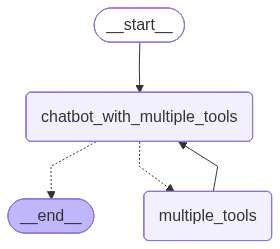

In [14]:
from IPython.display import Image, display

try:
    display(Image(graph_with_humaninloop.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [15]:
user_input = "I need some expert guidance for building an AI agent. Could you request assistance for me?"
config = {"configurable": {"thread_id": "1"}}

events = graph_with_humaninloop.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance for building an AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  human_assistance (8ac744f9-015e-4c2b-8b62-de5c194afb16)
 Call ID: 8ac744f9-015e-4c2b-8b62-de5c194afb16
  Args:
    query: I need expert guidance for building an AI agent.


In [16]:
snapshot = graph_with_humaninloop.get_state(config)
snapshot.next

('multiple_tools',)

In [17]:
human_response = (
    "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
    " It's much more reliable and extensible than simple autonomous agents."
)

human_command = Command(resume={"data": human_response})

events = graph_with_humaninloop.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  human_assistance (8ac744f9-015e-4c2b-8b62-de5c194afb16)
 Call ID: 8ac744f9-015e-4c2b-8b62-de5c194afb16
  Args:
    query: I need expert guidance for building an AI agent.
================================= Tool Message =================================
Name: human_assistance

"We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents."
================================== Ai Message ==================================

The experts recommend using LangGraph to build your AI agent. They say it's more reliable and extensible than simple autonomous agents.


### Testing the Bot's Memory

- Pick a thread to use as the key for this conversation
- Call the bot
- Ask follow up question

In [18]:
user_input = "Hi there! My name is Will."

# The config is the **second positional argument** to stream() or invoke()!
events = graph_with_humaninloop.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Will.
================================== Ai Message ==================================

Hi Will! How can I help you today?


In [19]:
user_input = "Remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph_with_humaninloop.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

Yes, your name is Will.


**Testing with Different Thread ID**

In [20]:
# The only difference is we change the `thread_id` here to "2" instead of "1"
events = graph_with_humaninloop.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    {"configurable": {"thread_id": "2"}},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

I do not have access to any personally identifiable information about you. I don't have memory of past conversations.


In [21]:
snapshot = graph_with_humaninloop.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='I need some expert guidance for building an AI agent. Could you request assistance for me?', additional_kwargs={}, response_metadata={}, id='673fa2d1-b413-40d7-8c4f-3590f812c7fd'), AIMessage(content='', additional_kwargs={'function_call': {'name': 'human_assistance', 'arguments': '{"query": "I need expert guidance for building an AI agent."}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--2bf41437-e209-4d7c-9e3f-7b5c6ec042aa-0', tool_calls=[{'name': 'human_assistance', 'args': {'query': 'I need expert guidance for building an AI agent.'}, 'id': '8ac744f9-015e-4c2b-8b62-de5c194afb16', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1122, 'output_tokens': 14, 'total_tokens': 1136, 'input_token_details': {'cache_read': 0}}), ToolMessage(content='"We, the experts are here to help! We\'d recommend you 

In [22]:
snapshot.next  # (since the graph ended this turn, `next` is empty. If you fetch a state from within a graph invocation, next tells which node will execute next)

()